In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,roc_auc_score, precision_score, recall_score, f1_score, log_loss
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, KFold

In [56]:
# Import infections cases
df_f0=pd.read_csv("Bases//Base_clean_corrected_F.csv")

df_f0.columns



Index(['id', 'fnyear', 'sexo', 'edad', 'provincia', 'id_provincia',
       'departamento', 'id_departamento', 'fecha', 'prueba_resistencia',
       'resistencia', 'droga', 'tipo_resistencia', 'prueba_vih',
       'resultado_hiv', 'embarazo', 'embarazo_y_o_puerperio', 'diabetes',
       'consumo_prob_drogas', 'enf_resp_cronica', 'covid', 'etnia',
       'tabaquismo', 'alcoholismo', 'estab_tto', 'inicio_trat',
       'fecha_fin_trat', 'resultado_tratamiento', 'link', 'salud',
       'poblacion_estimada', 'densidad_estimada', 'cod_prov', 'index obesity',
       'Nivel de incidencia de pobreza crónica',
       '% de población en situación de pobreza crónica',
       '% de población sin obra social ni prepaga', 'DD', 'FF', 'PNM', 'TEMP',
       'HUM', 'dia_semana', '1_o_15', 'Dia_Festivo', 'es_dia_laboral',
       'codprovdepto', 'LOCALIDAD_CORRECTA', 'localidad', 'CodLoc', 'codigo',
       'codigo_dpto', 'fecha_M', '% de hogares con hacinamiento crítico',
       '% de hogares con jefe/a co

In [57]:

import unidecode
import re

def normalizar_nombre(nombre):
    nombre = unidecode.unidecode(nombre.upper())  # mayúsculas y sin tildes
    nombre = re.sub(r'\bN[°º]\b', 'NUMERO', nombre)  # reemplaza Nº, N° por NUMERO
    nombre = re.sub(r'\bHOSPITAL\b', 'HOSP', nombre)

    nombre = re.sub(r'\bDOCTOR\b|\bDR\.\b|\bDR\b', 'DR', nombre)
    nombre = re.sub(r'[^A-Z0-9 ]', '', nombre)  # saca signos raros
    nombre = re.sub(r'\s+', ' ', nombre).strip()  # colapsa espacios
    return nombre



df_f0['estab_normalizado'] = df_f0['estab_tto'].astype(str).apply(normalizar_nombre)

df_f0['clave_establecimiento'] = (
    df_f0['id_provincia'].astype(str) + "_" +
    df_f0['id_departamento'].astype(str) + "_" +
    df_f0['estab_normalizado']
)

correcciones = {
    "HOSP GENERAL DE NINOS P DE ELIZALDE": "HOSP GENERAL DE NINOS PEDRO DE ELIZALDE",  # 94.6%
    "HOSP GENERAL DE AGUDOS DR J A FERNANDEZ": "HOSP GENERAL DE AGUDOS DR JUAN A FERNANDEZ",  # 96.3%
    "HOSP ZONAL ESP AGUDOS Y CRONICOS DR CETRANGOLO": "HOSP ZONAL ESPECIALIZADO AGUDOS Y CRONICOS DR CETRANGOLO",  # 90.2%
    "HOSP GENERAL DE AGUDOS D VELEZ SARSFIELD": "HOSP GENERAL DE AGUDOS DALMACIO VELEZ SARSFIELD",  # 92.0%
    "HOSP GENERAL DE NINOS RICARDO GUTIERREZ": "HOSP GENERAL DE NINOS DR RICARDO GUTIERREZ",  # 96.3%
    "HOSP GENERAL DE AGUDOS DR C ARGERICH": "HOSP GENERAL DE AGUDOS DR COSME ARGERICH",  # 94.7%
    "HOSP GENERAL DE AGUDOS DR E TORNU": "HOSP GENERAL DE AGUDOS DR ENRIQUE TORNU",  # 91.7%
    "HOSP GENERAL DE AGUDOS J A PENNA": "HOSP GENERAL DE AGUDOS JOSE A PENNA",  # 95.5%
    "HOSP DE REHABILITACION RESPIRATORIA M FERRER": "HOSP DE REHABILITACION RESPIRATORIA MARIA FERRER",  # 95.7%
    "HOSP GENERAL DE AGUDOS J M RAMOS MEJIA": "HOSP GENERAL DE AGUDOS JOSE MARIA RAMOS MEJIA",  # 91.6%
    "HOSP GENERAL DE AGUDOS DR C DURAND": "HOSP GENERAL DE AGUDOS DR CARLOS G DURAND",  # 90.7%
    "HOSP GENERAL DE AGUDOS DONACION F SANTOJANNI": "HOSP GENERAL DE AGUDOS DONACION FRANCISCO SANTOJANNI",  # 91.7%
    "HOSP GENERAL DE AGUDOS A ZUBIZARRETA": "HOSP GENERAL DE AGUDOS DR ABEL ZUBIZARRETA",  # 92.3%
    "HOSP DE SALUD MENTAL J BORDA": "HOSP DE SALUD MENTAL JOSE T BORDA",  # 91.8%
    "HOSP MUNICIPAL DR DE THOMPSON": "HOSP MUNICIPAL DR DIEGO E THOMPSON",  # 92.1%
    "HTAL CECILIA GRIERSON CTRO DE SALUD INTEGRAL": "HOSP CECILIA GRIERSON CENTRO DE SALUD INTEGRAL",  # 91.1%
    "HOSP LOCAL GRAL ANITA ELICAGARAY": "HOSP LOCAL GENERAL ANITA ELICAGARAY",  # 95.5%
    "HOSP INTERZONAL GRAL AGUDOS PRESIDENTE PERON": "HOSP INTERZONAL GENERAL AGUDOS PRESIDENTE PERON",  # 96.7%
    "HOSP GENERAL DE AGUDOS DR I PIROVANO": "HOSP GENERAL DE AGUDOS DR IGNACIO PIROVANO",  # 92.3%
    "HOSP INTERZONAL GRAL AGUDOS EVITA": "HOSP INTERZONAL GENERAL AGUDOS EVITA",  # 95.7%
    "HOSP CECILIA GRIERSON": "HOSP DRA CECILIA GRIERSON",  # 91.3%
    "HOSP ZONAL GRAL AGUDOS LUCIO MELENDEZ": "HOSP ZONAL GENERAL AGUDOS DR LUCIO V MELENDEZ",  # 90.2%
    "HOSP ZONAL GRAL AGUDOS DR ISIDORO IRIARTE": "HOSP ZONAL GENERAL AGUDOS DR ISIDORO IRIARTE",  # 96.5%
    "CTRO DE DIAGNOSTICO Y TRATAMIENTO DR JA SABATO": "CENTRO DE DIAGNOSTICO Y TRATAMIENTO DR JAVIER A SABATTO",  # 91.1%
    "HOSP INTERZONAL GRAL AGUDOS DR PEDRO FIORITO": "HOSP INTERZONAL GENERAL AGUDOS DR PEDRO FIORITO",  # 96.7%
    "INST MUNIC DE SALUD Y MEDICINA PREVENTIVA": "INSTITUTO MUNICIPAL DE SALUD Y MEDICINA PREVENTIVA",  # 90.1%
    "HOSP INTERZONAL GRAL AGUDOS LC DE GANDULFO": "HOSP INTERZONAL GENERAL AGUDOS L C DE GANDULFO",  # 95.5%
    "HOSP INTERZONAL AGUDOS Y CRONICOS SAN JUAN DE DIOS": "HOSP INTERZONAL DE AGUDOS Y CRONICOS SAN JUAN DE DIOS",  # 97.1%
    "HOSP ZONAL GRAL AGUDOS NARCISO LOPEZ": "HOSP ZONAL GENERAL AGUDOS NARCISO LOPEZ",  # 96.0%
    "HOSP GENERAL DE AGUDOS DR E TORNU NO RESIDENTES": "HOSP GENERAL DE AGUDOS DR C DURAND NO RESIDENTES",
    "HOSP SUBZONAL GRAL AGUDOS DE WILDE": "HOSP SUBZONAL GENERAL AGUDOS DE WILDE",  # 95.8%

    "CLIN PRIV FUMEBA HOSP PRIVADO DEL SUR": "CLINICA PRIVADA FUMEBA HOSP PRIVADO DEL SUR",  # 92.5%

    "HOSP SUBZONAL MUNICIPAL DR F FOSATTI": "HOSP SUBZONAL MUNICIPAL DR FELIPE A FOSATTI",  # 91.1%
    "HOSP SUBZONAL GRAL DR LINO PINEIRO": "HOSP SUBZONAL GENERAL DR LINO PINEIRO",  # 95.8%
    "HOSP ZONAL GRAL AGUDOS SAN ROQUE": "HOSP ZONAL GENERAL DE AGUDOS SAN ROQUE",  # 91.4%
    "HOSP ZONAL GRAL AGUDOS DR LARRAIN": "HOSP ZONAL GENERAL AGUDOS DR LARRAIN",  # 95.7%
    "UDAD HOSPITALARIA SAN JOSE": "UNIDAD HOSPITALARIA SAN JOSE",  # 96.3%
    "UNIDAD 21 SPB": "UNIDAD 21 SPB",  # 92.3%
    "HOSP GENERAL DE AGUDOS DRALBERTO EURNEKIAN": "HOSP ZONAL GENERAL DE AGUDOS DR ALBERTO EURNEKIAN",  # 92.3%
    "HOSP LOCAL GRAL EVA PERON": "HOSP LOCAL GENERAL EVA PERON",  # 94.3%
    "HOSP SUBZONAL MUNICIPAL NUESTRA SRA DEL CARMEN": "HOSP SUBZONAL MUNICIPAL NUESTRA SENORA DEL CARMEN",  # 96.8%
    "HOSP MUNICIPAL DR ROMANAZZI": "HOSP MUNICIPAL DR P ROMANAZZI",  # 96.4%
    "CTRO MATERNO INFANTIL AUDELINA SAMBRANO": "CENTRO MATERNO INFANTIL AUDELINA ZAMBRANO",  # 95.0%
    "HOSP ZONAL GRAL AGUDOS PETRONA V DE CORDERO": "HOSP ZONAL GENERAL AGUDOS PETRONA V DE CORDERO",  # 96.6%
    "POLICLIN SOFIA TERRERO DE SANTA MARINA": "POLICLINICO SOFIA TERRERO DE SANTAMARINA",  # 94.9%
    "UDAD SANITARIA N 15": "UNIDAD SANITARIA N 15",  # 95.0%
    "CAPS VILLA VATTEONE": "CENTRO DE SALUD VILLA VATTEONE",  # 100.0%
    "HOSP LOCAL MUNICIPAL FELIPE PELAEZ": "HOSP LOCAL MUNICIPAL DR FELIPE A PELAEZ",  # 93.2%
    "HOSP MUNICIPAL ANA BS DE MARTINEZ GUERRERO": "HOSP MUNICIPAL ANA ROSA S DE MARTINEZ GUERRERO",  # 93.2%
    "HOSP NACIONAL BALDOMERO SOMMER": "HOSP NACIONAL DR BALDOMERO SOMMER",  # 95.2%
    "CLIN 25 DE MAYO": "CLINICA 25 DE MAYO",  # 90.9%

    "UDAD SANITARIA N 13 VILLA LYNCH": "UNIDAD SANITARIA N 13 DE VILLA LYNCH",  # 92.5%
    "UDAD SANITARIA N 12 VILLA PIAGGIO": "UNIDAD SANITARIA N 12 DE VILLA PIAGGIO",  # 93.0%
    "HOSP MUNICIPAL DR R LARCADE": "HOSP MUNICIPAL DR RAUL LARCADE",  # 94.7%
    "POLICLIN CENTRAL SAN JUSTO": "POLICLINICO CENTRAL SAN JUSTO",  # 94.5%
    "UDAD SANITARIA MAR DEL TUYU": "UNIDAD SANITARIA MAR DEL TUYU",  # 96.4%
    "CLIN MODELO LOS CEDROS SA": "CLINICA s LOS CEDROS SA",  # 94.3%

    "HOSP RURAL RIO SENGUER": "HOSP RURAL RIO SENGUERR",  # 97.8%
    "CTRO REGIONAL DE REFERENCIA ARTURO ONATIVIA": "CENTRO REGIONAL DE REFERENCIA DR ARTURO ONATIVIA",  # 94.5%
    "CLIN MODELO SA": "CLINICA MODELO SA",  # 90.3%
    "HOSP FERMIN SALABERRY": "HOSP DR FERMIN SALABERRY",  # 93.3%
    "CTRO DE SALUD MARIANO BOEDO": "CTRO DE SALUD MARIANO MORENO",  # 90.9%
    "CTRO DE SALUD LOTE 47": "CTRO DE SALUD LOTE 47",  # 95.2%
    "HOSP PROVINCIAL SAN MARTIN N2": "HOSP PROVINCIAL SAN MARTIN N 2",  # 98.3%
    "HOSP SAN ROQUE": "HOSP SAN ROQUE 1",  # 93.3%
    "HOSP NTRA SENORA DEL ROSARIO": "HOSP NUESTRA SENORA DEL ROSARIO",  # 94.9%
    "HOSP NTRA SENORA DEL ROSARIO": "HOSP NUESTRA SENORA DEL ROSARIO 20",  # 90.3%
    "HOSP NUESTRA SENORA DEL ROSARIO": "HOSP NUESTRA SENORA DEL ROSARIO 20",  # 95.4%
    "HOSP DR ARTURO ZABALA": "HOSP DR ARTURO ZABALA 6",  # 95.5%
    "HOSP NUESTRA SENORA DEL CARMEN": "HOSP NUESTRA SENORA DEL CARMEN 5",  # 96.8%
    "HOSP PABLO SORIA": "HOSP DN PABLO SORIA",  # 91.4%
    "HOSP ING CARLOS SNOPEK": "HOSP ING CARLOS SNOPEK 2",  # 95.7%
    "CTRO DE SALUD SANTA ROSA": "CTRO DE SALUD SANTA ROSA",  # 91.7%


    "HOSP DR GUILLERMO PATERSON": "HOSP DR GUILLERMO C PATERSON 7",  # 92.9%
    "HOSP PRESBITERO ESCOLASTICO ZEGADA": "HOSP PRESBITERO ESCOLASTICO ZEGADA 10",  # 95.8%
    "HOSP CALILEGUA": "HOSP CALILEGUA 12",  # 90.3%
    "HOSP SAN MIGUEL": "HOSP SAN MIGUEL 13",  # 90.9%
    "HOSP WENCESLAO GALLARDO": "HOSP WENCESLAO GALLARDO 4",  # 95.8%
    "HOSP LA MENDIETA": "HOSP LA MENDIETA 9",  # 94.1%
    "HOSP NUESTRA SENORA DEL PILAR": "HOSP NUESTRA SENORA DEL PILAR 14",  # 95.1%
    "HOSP NUESTRA SENORA DEL VALLE": "HOSP NUESTRA SENORA DEL VALLE 15",  # 95.1%
    "HOSP DR JORGE URO": "HOSP DR JORGE URO 21",  # 91.9%
    "HOSP DR SALVADOR MAZZA": "HOSP DR SALVADOR MAZZA 18",  # 93.6%
    "HOSP LUIS C LAGOMAGGIORE": "HOSP LUIS CARLOS LAGOMAGGIORE",  # 90.6%
    "HOSP TEODORO SCHESTAKOW": "HOSP TEODORO J SCHESTAKOW",  # 95.8%
    "HOSP HUMBERTO NOTTI": "HOSP HUMBERTO J NOTTI",  # 95.0%
    "HOSP ALFREDO I PERRUPATO": "HOSP ALFREDO ITALO PERRUPATO",  # 92.3%
    "HOSP DOMINGO SICOLI": "HOSP DOMINGO S F SICOLI",  # 90.5%
    "HOSP ANTONIO SCARAVELLI": "HOSP ANTONIO J SCARAVELLI",  # 95.8%
    "HOSP CARLOS SAPORITI": "HOSP CARLOS F SAPORITI",  # 95.2%
    "SANATORIO NOZIGLIA SA": "SANATORIO NOZIGLIA SA",  # 95.2%
    "HOSP RAMON VILLAFANE": "HOSP DR RAMON VILLAFANE",  # 93.0%
    "CLIN SAN RAFAEL SA": "CLINICA SAN RAFAEL SA",  # 92.3%
    "HOSP DR SALVADOR MAZZA": "HOSP PROF SALVADOR MAZZA",  # 91.3%
    "HOSP SAN VICENTE PAUL": "HOSP SAN VICENTE DE PAUL",  # 93.3%
    "HOSP JOAQUIN CORBALAN": "HOSP DR JOAQUIN CORBALAN",  # 93.3%
    "HOSP DR LM ANZOATEGUI": "HOSP DR LUIS ANZOATEGUI",  # 90.9%
    "HOSP EL CARMEN": "HOSP DEL CARMEN",  # 96.6%


    "CLIN REGIONAL DEL SUD": "CLINICA REGIONAL DEL SUD",  # 93.3%
    "CTRO MEDICO SA": "CENTRO MEDICO SA",  # 93.3%
    "SANATORIO DEL NORTE": "SANATORIO DEL NORTE SRL",  # 90.5%
    "HOSP DR RICARDO BILLINGHURST": "HOSP DR RICARDO BILLINGHURST",  # 96.4%
    "HOSP SAN LUIS DEL PALMAR": "HOSP BASE SAN LUIS DEL PALMAR",  # 90.6%
    "HOSP 4 DE JUNIO RAMON CARRILLO": "HOSP 4 DE JUNIO DR RAMON CARRILLO",  # 95.2%
    "HOSP DE LA HERMANDAD ARGENTINOPARAGUAYA": "HOSP DE LA HERMANDAD ARGENTINO PARAGUAYA",  # 98.7%
    "HOSP PEDIATRICO DR AVELLINO L CASTELAN": "HOSP PEDIATRICO DR AVELINO LORENZO CASTELAN",  # 91.4%
    "HOSP ENRIQUE V DE LLAMAS": "HOSP DR ENRIQUE V DE LLAMAS",  # 94.1%
    "HOSP ISAAC WAISMAN": "HOSP DR ISAAC WAISMAN",  # 92.3%
    "HOSP DANTE TARDELLI": "HOSP DR DANTE TARDELLI",  # 92.7%
    "CTRO DE SALUD LOTE 202": "CTRO DE SALUD LOTE 202",  # 95.5%
    "COMPLEJOS ASIST SA INST RCHED MOSELLI I": "COMPLEJOS ASIST SA INST RCHED MOSELLI II",  # 98.7%
    "CENTRO DE SALUD NESTOR KIRCHNER": "CENTRO DE SALUD NESTOR C KIRCHNER",  # 93.8%
    "CTRO DE SALUD LOTE 47": "CTRO DE SALUD LOTE 47",  # 95.2%
    "CTRO DE SALUD SANTA ROSA": "CTRO DE SALUD SANTA ROSA",  # 91.7%
    "CTRODE SALUD 820 VIVIENDAS": "CTRO DE SALUD 249 VIVIENDAS",  # 90.6%

    "SANATORIO NOZIGLIA SA": "SANATORIO NOZIGLIA SA",  # 95.2%
    "CLIN PRIVADA SAGRADO CORAZON": "CLINICA PRIVADA SAGRADO CORAZON SA",  # 90.3%
    "HOSP CNEL JUAN SOLA": "HOSP CORONEL JUAN SOLA",  # 92.7%
    "HOSP JUAN CARLOS DAVALOS": "HOSP DR JUAN CARLOS DAVALOS",  # 94.1%
    "CTRO DE SALUD SAMCO": "CTRO DE SALUD N 3 SAMCO",  # 90.5%
    "SAMCO MAXIMO PAZ": "SAMCO DE MAXIMO PAZ",  # 91.4%
    "CTRO ASIST BARRIO NORTE": "CTRO ASIST BARRIO NORESTE",  # 95.8%
    "COLONIA PSIQUIATRIA DR A IRIGOYEN FREYRE": "COLONIA PSIQUIATRICA DR ABELARDO IRIGOYEN FREYRE",  # 90.9%
    "CTRO DE SALUD CANDIOTI": "CTRO DE SALUD B CANDIOTI",  # 95.7%
    "POLICINICO VECINAL": "CENTRO DE SALUD POLICLINICO VECINAL",  # 97.3%
    "HOSP DE EMERGENCIAS DR CLEMENTE ALVAREZ": "M HOSP DE EMERGENCIAS DR CLEMENTE ALVAREZ",  # 97.5%
    "CENTRO DE SALUD DAVID STAFFIERI": "CENTRO DE SALUD DR DAVID STAFFIERI",  # 90.9%
    "CTRO REGIONAL DE SALUD MENTAL DR AGUDO AVILA": "CENTRO REGIONAL DE SALUD MENTAL DR AGUDO AVILA",  # 97.8%
    "CTRO DE SALUD JUAN B JUSTO": "M CTRO DE SALUD JUAN B JUSTO",  # 96.3%
    "M POLICLIN GRAL SAN MARTIN": "CENTRO DE SALUD POLICLIN GRAL SAN MARTIN",  # 96.0%
    "CS CONSTANCIO C VIGIL": "DISP CONSTANCIO C VIGIL",  # 90.9%
    "HOSP JUAN BAUTISTA ALBERDI": "HOSP DR JUAN BAUTISTA ALBERDI",  # 94.5%
    "SAMCO IBARLUCEA": "SAMCO DE IBARLUCEA",  # 90.9%
    "CS POCHO LEPRATTI": "CENTRO DE SALUD POCHO LEPRATTI",  # 90.3%
    "SANATORIO PARQUE": "SANATORIO PARQUE SA",  # 91.4%
    "SANATORIO PLAZA": "SANATORIO PLAZA SA",  # 90.9%
    "SANATORIO NUESTRA SENORA DEL ROSARIO": "SANATORIO NUESTRA SENORA DEL ROSARIO IPAM",  # 93.5%
    "SANATORIO MAPACI": "SANATORIO MAPACI SA",  # 91.4%
 

    "SAMCO VILLA MUGUETA": "SAMCO DE VILLA MUGUETA",  # 92.7%
    "HOSP CENTRO DE SALUD ZENON J SANTILLAN": "HOSP CENTRO DE SALUD DR ZENON SANTILLAN",  # 93.5%

    "HOSP MILITAR CENTRAL CIRUJANO MAYOR COSME ARGERICH": "HOSP MILITAR CENTRAL CIRUJANO MAYOR DR COSME ARGERICH",  # 97.1%
    "UDAD SANITARIA VALENTIN ALSINA": "UNIDAD SANITARIA VALENTIN ALSINA",  # 96.8%
    "UNIDAD 1 SPB": "UNIDAD 1 SPB",  # 91.7%
    "HOSP ZONAL GRAL LOBOS": "HOSP ZONAL GENERAL LOBOS",  # 93.3%

    "HOSP LOCAL GRAL AGUDOS DR R CARRILLO": "HOSP LOCAL GENERAL AGUDOS DR RAMON CARRILLO",  # 91.1%
    "UDAD SANITARIA SANTA CLARA DEL MAR": "UNIDAD SANITARIA SANTA CLARA DEL MAR",  # 97.1%
    "HOSP ZONAL GRAL AGUDOS BLAS DUBARRY": "HOSP ZONAL GENERAL AGUDOS BLAS DUBARRY",  # 95.9%
    "HOSP INTERZONAL GRAL AGUDOS DR L GUEMES": "HOSP INTERZONAL GENERAL AGUDOS DR LUIS A GUEMES",  # 90.7%
    "HOSP MUNICIPAL DR M ARCE": "HOSP MUNICIPAL DR MANUEL ARCE",  # 90.6%
    "UNIDAD 2 SPB": "UNIDAD 27 SPB",  # 96.0%
    "HOSP LOCAL GRAL PEDRO LURO": "HOSP LOCAL GENERAL PEDRO LURO",  # 94.5%
    "UDAD SANITARIA LA LOMITA": "UNIDAD SANITARIA LA LOMITA",  # 96.0%
    "UDAD SANITARIA SAN ALEJO": "UNIDAD SANITARIA SAN ALEJO",  # 96.0%
    "UDAD SANITARIA PRESIDENTE DERQUI": "UNIDAD SANITARIA PRESIDENTE DERQUI",  # 97.0%
    "UDAD SANITARIA RIO LUJAN": "UNIDAD SANITARIA RIO LUJAN",  # 96.0%
    "UDAD SANITARIA LA FLORIDA": "UNIDAD SANITARIA LA FLORIDA",  # 96.2%
    "UDAD SANITARIA RENE FAVALORO": "UNIDAD SANITARIA RENE FAVALORO",  # 96.6%
    "HOSP ZONAL GRAL DR ALEJANDRO POSADAS": "HOSP ZONAL GENERAL DR ALEJANDRO POSADAS",  # 96.0%
    "HOSP LOCAL GRAL DE SALTO": "HOSP LOCAL GENERAL DE SALTO",  # 94.1%
    "HOSP MUNICIPAL ALBERTO MENDITEGUY": "HOSP MUNICIPAL DR ALBERTO MENDITEGUY",  # 95.7%
    "HOSP ZONAL ESPECIALIZADO AGUDOS Y CRONICOS DR CETRANGOLO": "HOSP ZONAL ESPECIALIZADO AGUDOS Y CRONICOS DR CENTRANGOLO",  # 99.1%
    "UDAD SANITARIA H BERTRES": "UNIDAD SANITARIA H BERTRES",  # 96.0%

    "CAPS TRONCOS DEL TALAR": "CENTRO DE SALUD TRONCOS DEL TALAR",  # 100.0%
    "SANATORIO PASTEUR": "SANATORIO PASTEUR SA",  # 91.9%
    "HOSP SANITARIO INTERZONAL DE NINOS EVA PERON": "ESTAB SANITARIO INTERZONAL DE NINOS EVA PERON",  # 92.1%
    "HOSP ZONAL GRAL VICENTE LOPEZ Y PLANES": "HOSP INTERZONAL GENERAL VICENTE LOPEZ Y PLANES",  # 90.5%
    "CLIN CHUTRO SRL": "CLINICA CHUTRO SRL",  # 90.9%
    "HOSP REGIONAL DE CONCEPCION DR M BELASCUAIN": "HOSP REGIONAL CONCEPCION DR MIGUEL BELASCUAIN",  # 90.9%
    "HOSP CTRO DE SALUD AGUILARES": "HOSP CENTRO DE SALUD AGUILARES",  # 96.6%

    "HOSP DE INFECCIOSAS F MUNIZ": "HOSP DE INFECCIOSAS FRANCISCO MUNIZ",  # 87.1%
    "HOSP ZONAL GRAL AGUDOS DR PAROISSIEN": "HOSP INTERZONAL GENERAL AGUDOS DR PAROISSIEN",  # 90.0%
    "HOSP GENERAL DE AGUDOS B RIVADAVIA": "HOSP GENERAL DE AGUDOS BERNARDINO RIVADAVIA",  # 88.3%

    "HOSP INTERZONAL GENERAL AGUDOS EVITA": "HOSP INTERZONAL GENERAL DE AGUDOS EVA PERON",  # 86.1%

    "M CONS MED ASOC VECINAL LA FLORIDA CONS EXTERNOS": "M CONS MED ASOC VECINAL JULIO A ROCA CONS EXTERNOS",  # 87.8%
    "CS DRJULIO MAIZTEGUI": "CENTRO DE SALUD DR JULIO MAIZTEGUI",  # 89.5%

    "CENTRO DE SALUD MARIA JOSEFA ROSSELLO": "CENTRO DE SALUD SANTA MARIA JOSEFA ROSELLO",  # 85.1%

    "CENTRO DE SALUD EMPALME GRANEROS": "CENTRO DE SALUD N 94 EMPALME GRANEROS",  # 86.5%
    "SAMCO VILLA GOBERNADOR GALVEZ": "CENTRO DE SALUD SAN MARTIN VILLA GOBERNADOR GALVEZ",  # 85.7%


    "SAMCO ROLDAN": "SAMCO DE ROLDAN",  # 88.9%

    "UDAD PRIMARIA DE AT N 1 BARRIO BORGES": "UDAD PRIMARIA DE AT N 1 BARRIO BORGES",  # 86.5%

    "HOSP DR ALVARO GOMEZ LLUECA": "HOSP DR ALVARO GOMEZ LLUECA SIMOCA",  # 88.5%
    "HOSP REGIONAL NUESTRA SENORA DE LA CANDELARIA": "HOSP REGIONAL NUESTRA SRA DE LA CANDELARIA CONS EXT",  # 87.5%
    "HOSP REGIONAL NUESTRA SRA DE LA CANDELARIA CONS EXT": "HOSP REGIONAL NUESTRA SRA DE LA CANDELARIA INTERNACION",  # 87.6%

    "HOSP REG USHUAIA GOB JUAN MANUEL CAMPOS GUARDIA": "HOSP REG USHUAIA GOB JUAN MANUEL CAMPOS INTERNACION",  # 85.7%
    "HOSP REG USHUAIA GOB JUAN MANUEL CAMPOS CONS EXT": "HOSP REG USHUAIA GOB JUAN MANUEL CAMPOS INTERNACION",  # 86.9%

    "CTRO DE SALUD BO TOBA": "CTRO DE SALUD BO TOBA",  # 85.7%

    "CTRO DE SALUD GENERAL OBLIGADO": "CTRO DE SALUD GENERAL OBLIGADO",  # 90.0%

    "CTRO DE SALUD SANTA INES": "CTRO DE SALUD SANTA INES",  # 87.5%

    "CTRO DE SALUD VILLA LIBERTAD": "CTRO DE SALUD VILLA LIBERTAD",  # 85.7%
    "HOSP ZONAL ANDRES ISOLA": "HOSP SUBZONAL DR ANDRES ISOLA",  # 88.5%
    "HOSP SUBZONAL SANTA TERESITA": "HOSP SUB ZONAL RAWSON SANTA TERESITA",  # 87.5%
    "HOSP FRANCISCO RAMIREZ": "HOSP GRAL FRANCISCO RAMIREZ",  # 89.8%
    "CLIN DE NEFROLOGIA UROLOGIA Y ENFERMEDADES CARDIOVASCULARES SA": "SANATORIO DE NEFROLOGIA UROLOGIA Y ENFERMEDADES CARDIOVASCULARES",  # 88.9%
    "HTAL PROVINCIAL LAGUNA YEMA": "HTAL PROVINCIAL LAGUNA YEMA",  # 88.9%
    "DISP DE VIAS RESPIRATORIAS": "DISPENSARIO DE VIAS RESPIRATORIAS",  # 88.1%
    "CTRO DE SALUD 8 DE OCTUBRE": "CTRO DE SALUD BO 12 DE OCTUBRE",  # 89.3%
    "HOSP DR J CASTELLANOS": "HOSP DR JOAQUIN CASTELLANOS",  # 87.5%
    "CTRO DE SALUD LA VINA": "CTRO DE SALUD LA VINA",  # 85.7%

    "HOSP GENERAL BELGRANO": "HOSP GENERAL M BELGRANO 19",  # 89.4%
    "HOSP GENERAL M BELGRANO 19": "HOSP GENERAL MANUEL BELGRANO",  # 85.2%
    "HOSP DROSCAR ORIAS": "HOSP DR OSCAR ORIAS 11",  # 90.0%


    "HOSP NTRO SENOR LA BUENA ESPERANZA": "HOSP NUESTRO SENOR DE LA BUENA ESPERANZA 8",  # 89.5%
    "HOSP PROF SALVADOR MAZZA": "HOSP DR SALVADOR MAZZA 18",  # 85.7%
    "HOSP MAIMARA": "HOSP MAIMARA 16",  # 88.9%

    "COLONIA PENAL DE SANTA ROSA": "UNIDAD 4 COLONIA PENAL DE SANTA ROSA",  # 85.7%
    "HOSP SAMIC DE OBERA NIVEL III": "HOSP SAMIC DE ELDORADO NIVEL III",  # 88.5%
    "HOSP PUBLICO NUESTRA SENORA DE FATIMA": "HOSP NIVEL II NUESTRA SENORA DE FATIMA",  # 85.3%


    "HOSP JUNIN DE LOS ANDES": "HOSP JUNIN DE LOS ANDES",  # 87.0%
    "HOSP RINCON DE LOS SAUCES": "HOSP RINCON DE LOS SAUCES",  # 88.0%

}

def limpiar(nombre):
    return re.sub(r'\s+', ' ', nombre.strip())

df_f0['estab_normalizado'] = df_f0['estab_normalizado'].apply(limpiar)

df_f0['estab_normalizado'] = df_f0['estab_normalizado'].replace(correcciones)

len(df_f0['estab_normalizado'].unique()),len(df_f0['estab_tto'].unique())


from rapidfuzz import fuzz
import pandas as pd
import unidecode
import re
from collections import defaultdict
sugerencias = defaultdict(list)
grupos = df_f0.groupby(['id_provincia', 'id_departamento'])
no_contar=["HOSP", "DR",'CESAC']
sugerencias = defaultdict(list)

frases_ignorar = [
    "CENTRO DE ATENCION PRIMARIA DE SALUD",
    "HOSPITAL GENERAL DE AGUDOS",
    "HOSPITAL DEPARTAMENTAL",
    "CENTRO DE SALUD",
    "CAPS",
    "CESAC"
]

def recortar_encabezado(nombre):
    nombre = nombre.strip()
    for frase in frases_ignorar:
        if nombre.startswith(frase):
            return nombre[len(frase):].strip()
    return nombre


for (prov, dpto), subdf in df_f0.groupby(['id_provincia', 'id_departamento']):
    nombres = subdf['estab_normalizado'].unique()
    for i, n1 in enumerate(nombres):
        n1_cmp = recortar_encabezado(n1)
        for n2 in nombres[i+1:]:
            n2_cmp = recortar_encabezado(n2)
            score = fuzz.ratio(n1_cmp, n2_cmp)

            if score > 85 and score <=90 and n1 != n2:
                sugerencias[(prov, dpto)].append((n1_cmp, n2_cmp, score))


# Mostrar sugerencias para revisión manual
# Mostrar sugerencias y generar correcciones hacia el nombre más largo
vistos = set()
print("\n### Posibles correcciones (formato dict, hacia nombre más largo) ###\n")
i=0
for key, pares in sugerencias.items():
    for n1, n2, score in pares:
        if (n1, n2) not in vistos and (n2, n1) not in vistos:
            vistos.add((n1, n2))
            
            # Elegir el más largo como "correcto"
            nombre_largo = max(n1, n2, key=len)
            nombre_corto = min(n1, n2, key=len)

            # print(f'    "{nombre_corto}": "{nombre_largo}",  # {score:.1f}%')
            i=i+1



### Posibles correcciones (formato dict, hacia nombre más largo) ###



In [58]:
# Top n establecimientos por localidad
top_n = 2
establecimientos_por_codigo = (
    df_f0.groupby("link")["estab_normalizado"]
    .value_counts()
    .groupby(level=0)
    .nlargest(top_n)
    .reset_index(level=0, drop=True)
    .index
)

# Crear columna agrupada
def reducir_estab(row):
    key = (row["link"], row["estab_normalizado"])
    return row["estab_normalizado"] if key in establecimientos_por_codigo else f"Otros_{row['codigo']}"

# df_f0["estab_reducido"] = df_f0.apply(reducir_estab, axis=1)


In [59]:
# modo_por_codigo = (
#     df_f0.groupby("codigo")["estab_normalizado"]
#     .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
# )

# # 2. Crear una columna de imputación
# df_f0["estab_normalizado_imputado"] = df_f0["estab_normalizado"]

# # 3. Llenar los NaN usando el modo correspondiente
# df_f0.loc[df_f0["estab_normalizado_imputado"].isna(), "estab_normalizado_imputado"] = (
#     df_f0.loc[df_f0["estab_normalizado_imputado"].isna(), "codigo"]
#     .map(modo_por_codigo)
# )

In [60]:
df_f0=df_f0.loc[df_f0["edad"]>0]


In [61]:

df_f0['mes']=pd.to_datetime(df_f0['fecha']).dt.month

df_f0["periodo"]=df_f0['fnyear'].astype(str)+"-"+df_f0['mes'].astype(str)



In [62]:
df_f0["dias_tratamiento"]=pd.to_datetime(df_f0["fecha_fin_trat"])-pd.to_datetime(df_f0["inicio_trat"])

df_f0["dias_tratamiento"]=df_f0.loc[~df_f0["dias_tratamiento"].isna(),"dias_tratamiento"].dt.days.astype(int)
df_f0=df_f0.loc[~df_f0["resultado_tratamiento"].isnull()]

df_f0['resultado_tratamiento_bin'] = df_f0['resultado_tratamiento'].map({
    'Éxito': 1,
    'Fracaso':  0
})

mean_target_local = (
    df_f0.groupby(["codigo", "estab_normalizado"])["resultado_tratamiento_bin"]
    .mean()
    .rename("estab_target_mean")
    .reset_index()
)

df_f0 = df_f0.merge(mean_target_local, on=["codigo", "estab_normalizado"], how="left")


In [63]:

# Codificás por separado (ej: OneHotEncoding o target mean por nivel)
df_f0["prov_mean"] = df_f0["id_provincia"].map(df_f0.groupby("id_provincia")["resultado_tratamiento_bin"].mean())
df_f0["dep_mean"] = df_f0["link"].map(df_f0.groupby("link")["resultado_tratamiento_bin"].mean())
df_f0["loc_mean"] = df_f0["CodLoc"].map(df_f0.groupby("CodLoc")["resultado_tratamiento_bin"].mean())

# Usás esas 3 columnas y descartás los IDs originales
df_f0 = df_f0.drop(columns=["id_provincia", "link", "CodLoc"])

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import joblib

# # 1. Separar datos
# X = df_f0[['fnyear','mes','periodo', 'sexo', 'edad', 

#       'salud', 'poblacion_estimada',
#        'densidad_estimada','pcia',
#  'DD', 'FF', 'PNM', 'TEMP',
#        'HUM', 'Dia Festivo', '1 o 15', 'dia_semana', 'es_dia_laboral',
#        'resistencia','embarazo_y_o_puerperio', 'diabetes', 'consumo_prob_drogas', 'etnia',
#        'tabaquismo', 'alcoholismo', 'dias_tratamiento',
#        'resultado_tratamiento', 'resultado_hiv', 'enfermedad respiratoria'  ]]


X = df_f0[[ 'sexo', 'edad', 'prov_mean',
       
       'prueba_resistencia', 'resistencia', 'droga', 'tipo_resistencia',
       'prueba_vih',  'embarazo', 'embarazo_y_o_puerperio',
       'diabetes', 'consumo_prob_drogas', 'enf_resp_cronica', 'covid', 'etnia',
       'tabaquismo', 'alcoholismo', 
       'resultado_tratamiento', 'resultado_hiv', 'dep_mean', 'salud','dias_tratamiento',
       'poblacion_estimada', 'densidad_estimada',  'index obesity',
       'Nivel de incidencia de pobreza crónica',
       


       'TEMP',
       'HUM',  '1_o_15', 'Dia_Festivo', 'es_dia_laboral','mes',
       '% de hogares con hacinamiento crítico',
       '% de hogares con jefe/a con primario completo o menos',
       '% de hogares con jefe/a con secundario incompleto o menos',
       '% de hogares en vivienda deficitaria',
       '% de hogares sin acceso a red cloacal','loc_mean']]
y = df_f0[['resultado_tratamiento_bin']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


In [65]:
df_f0['resultado_tratamiento'].unique()

from sklearn.utils.multiclass import type_of_target
print(type_of_target(y_train))

binary


In [66]:


# 2. Preprocesado
numeric_features = ['edad','prov_mean','dep_mean','loc_mean',
                    'salud', 'poblacion_estimada',
                    'densidad_estimada', 
                 'TEMP','HUM',
        'dias_tratamiento', 'index obesity', 'Nivel de incidencia de pobreza crónica',
       '% de hogares con hacinamiento crítico',
       '% de hogares en vivienda deficitaria',
       '% de hogares sin acceso a red cloacal',
       
            
       '% de hogares con jefe/a con secundario incompleto o menos',
       '% de hogares con jefe/a con primario completo o menos',
       ]
categorical_features = [ 'es_dia_laboral', 'mes',
       'embarazo_y_o_puerperio', 'diabetes', 'consumo_prob_drogas', 'etnia', 'tabaquismo', 'alcoholismo', 'resistencia', 'resultado_hiv',"1_o_15","Dia_Festivo",
       'covid','droga','embarazo','prueba_resistencia','prueba_vih','tipo_resistencia','enf_resp_cronica','sexo']

# categorical_features = ['sexo','provincia','link','1_o_15', 'dia_semana', 'link','es_dia_laboral', 'periodo']


# Supongamos que tu DataFrame se llama X
all_cols = set(X_train.columns)

# Listas que ya definiste
numeric = set(numeric_features)
categorical = set(categorical_features)

# Columnas aún no asignadas
unassigned = all_cols - numeric - categorical

print("Columnas sin asignar:")
for col in sorted(unassigned):
    print(" -", col)



Columnas sin asignar:
 - resultado_tratamiento


In [67]:

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# ——————————————————————————————
# 3. Construye tu pipeline con SMOTE + RandomForest limitado
# ——————————————————————————————

pipeline = ImbPipeline([
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        random_state=42,
        class_weight='balanced'  # opcional, ayuda con desequilibrio
    ))
])


# 4. Espacio de hiperparámetros
param_grid = {
    'clf__n_estimators': [100, 300,600],
    'clf__max_depth': [None, 10,20,30],
    'clf__min_samples_leaf': [1, 5,10]
}



🎯 Top 20 variables (agrupadas correctamente incluso con '_'):
                                              feature  importance
26                                      resultado_hiv    0.209012
9                                    dias_tratamiento    0.200061
0                                                edad    0.131861
18                                                mes    0.081831
34                                   tipo_resistencia    0.046337
36                                               sexo    0.041883
2                                            dep_mean    0.036824
30                                              droga    0.036072
5                                  poblacion_estimada    0.031340
10                                      index obesity    0.021742
4                                               salud    0.017718
6                                   densidad_estimada    0.016889
27                                             1_o_15    0.015361
14            

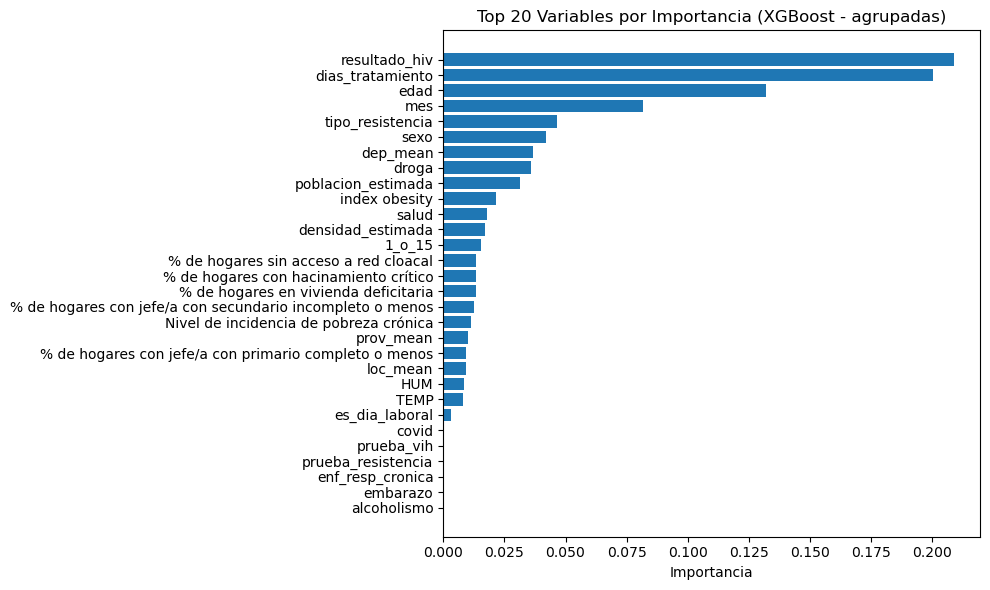

In [68]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# 1. Ajuste del preprocesador y transformación
preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)

# 2. Nombres de features
feature_names = preprocessor.get_feature_names_out()

# 3. Entrenar modelo XGB rápido
fast_xgb = XGBClassifier(
    n_estimators=50,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.7,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
fast_xgb.fit(X_train_proc, y_train)

# 4. Importancia base
raw_importances = pd.Series(fast_xgb.feature_importances_, index=feature_names)

# 5. Agrupación robusta por variable original
grouped_importance = defaultdict(float)

for name, value in raw_importances.items():
    if name.startswith("num__"):
        parent = name.replace("num__", "")
    elif name.startswith("cat__"):
        # cat__resultado_hiv_Positivo → resultado_hiv
        without_prefix = name.replace("cat__", "")
        parent = without_prefix.rsplit("_", 1)[0]  # corta desde la derecha
    else:
        parent = name

    grouped_importance[parent] += value

# 6. A DataFrame
df_grouped = (
    pd.DataFrame(grouped_importance.items(), columns=["feature", "importance"])
    .sort_values(by="importance", ascending=False)
)

# 7. Mostrar resultados
print("🎯 Top 20 variables (agrupadas correctamente incluso con '_'):")
print(df_grouped.head(30))

# 8. Gráfico
plt.figure(figsize=(10, 6))
df_top = df_grouped.head(30)
plt.barh(df_top["feature"][::-1], df_top["importance"][::-1])
plt.title("Top 20 Variables por Importancia (XGBoost - agrupadas)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()


                                    feature  importance
0                                           estab_tto    0.201741
1                                       resultado_hiv    0.147787
2                                              codigo    0.092349
3                                    dias_tratamiento    0.048362
4                                    tipo_resistencia    0.047874
5                                                edad    0.044661
6                                        id_provincia    0.043201
7                                                link    0.041409
8                                  poblacion_estimada    0.032033
9                                                sexo    0.031742
10                                  densidad_estimada    0.028941
11                                            periodo    0.026706
12                                    id_departamento    0.022567
13                                      index obesity    0.019797
14  % de hogares con jefe/a con secundario incompl...    0.017395
15                                                PNM    0.017303
16                                           diabetes    0.016201
17                                              salud    0.015975
18                                             fnyear    0.014744
19                                                 FF    0.013627
20                                              droga    0.009333
21                                         dia_semana    0.008674
22              % de hogares sin acceso a red cloacal    0.007354
23                                                mes    0.007303
...
42                                        resistencia    0.000000
43                                        alcoholismo    0.000000
44                                         tabaquismo    0.000000
45                                   enf_resp_cronica    0.000000

In [69]:
lista_20=list(df_grouped["feature"].head(20))
# lista_20.remove('estab_reducido_Otros')
X_train_2=X_train[lista_20]
X_train_2.columns

Index(['resultado_hiv', 'dias_tratamiento', 'edad', 'mes', 'tipo_resistencia',
       'sexo', 'dep_mean', 'droga', 'poblacion_estimada', 'index obesity',
       'salud', 'densidad_estimada', '1_o_15',
       '% de hogares sin acceso a red cloacal',
       '% de hogares con hacinamiento crítico',
       '% de hogares en vivienda deficitaria',
       '% de hogares con jefe/a con secundario incompleto o menos',
       'Nivel de incidencia de pobreza crónica', 'prov_mean',
       '% de hogares con jefe/a con primario completo o menos'],
      dtype='object')

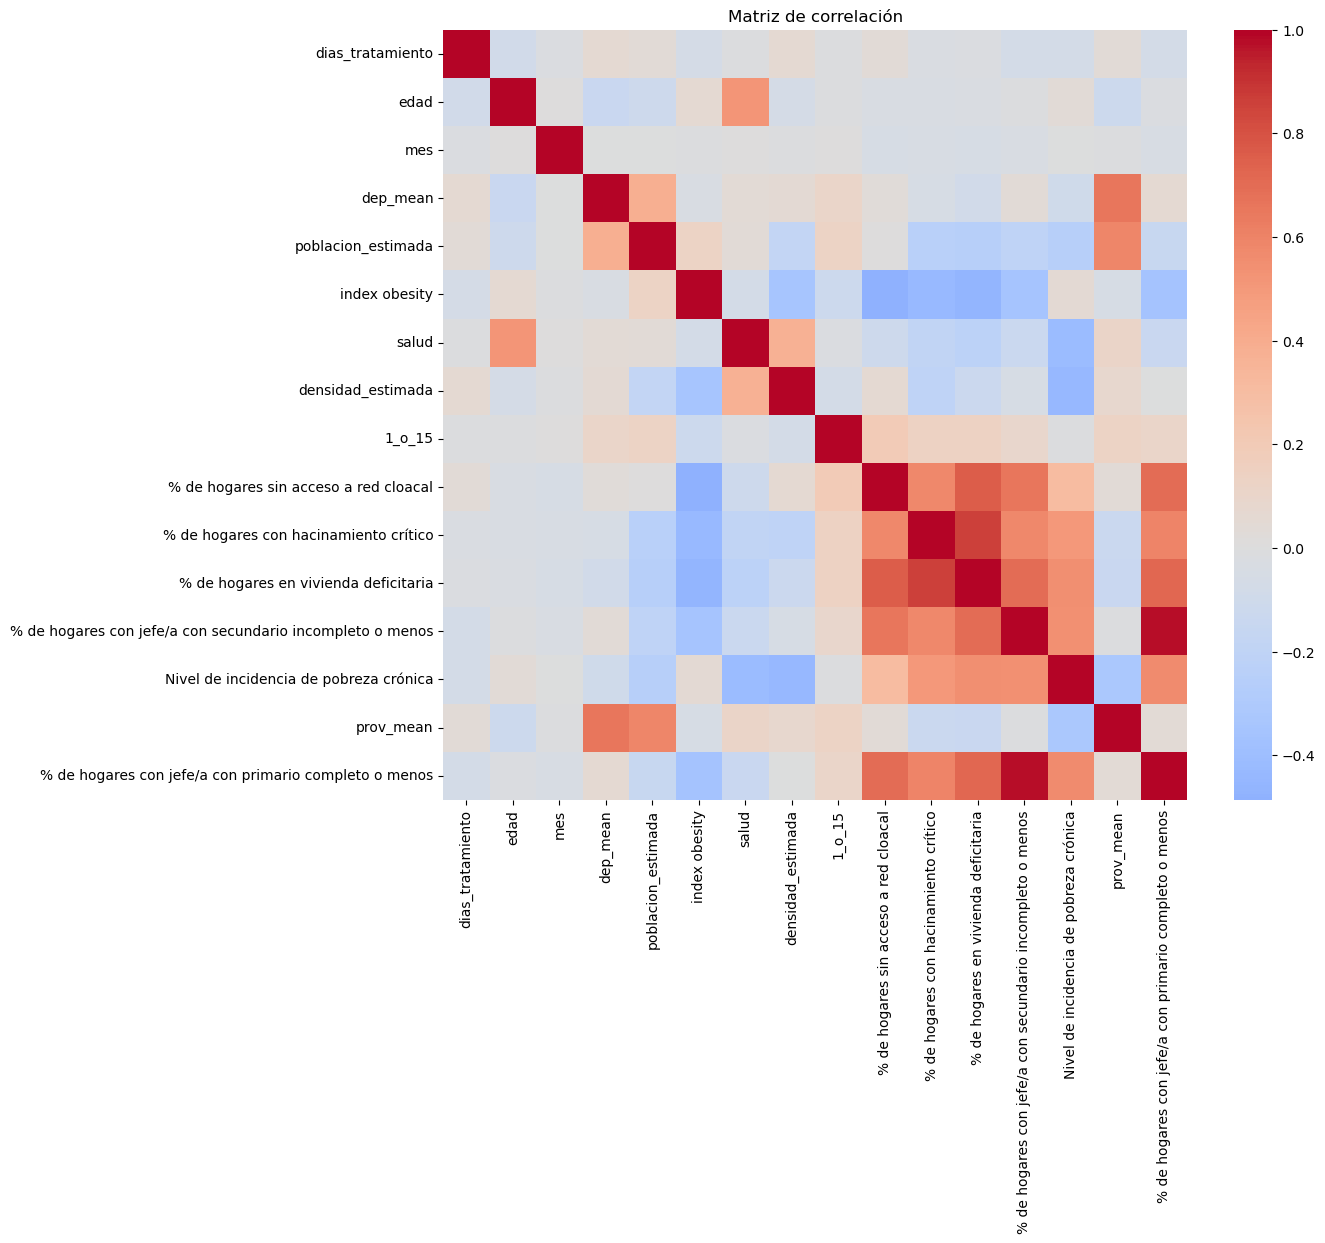

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de correlación
corr = X_train_2.corr(numeric_only=True)

# Visualización
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Matriz de correlación")
plt.show()


In [71]:
numeric_features2 = [col for col in numeric_features 
                       if col in X_train_2.columns]

categorical_features2= [col for col in categorical_features 
                       if col in X_train_2.columns]

categorical_features2

['mes', 'resultado_hiv', '1_o_15', 'droga', 'tipo_resistencia', 'sexo']

In [77]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow import keras
from tensorflow.keras import layers


import numpy as np
import pandas as pd

# Detectar tipos de columnas
cat_cols = X_train_2.select_dtypes(include="object").columns.tolist()
num_cols = X_train_2.select_dtypes(include=np.number).columns.tolist()

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline  # evitar confusión con sklearn.pipeline

preprocessor = ColumnTransformer(transformers=[
    ("num", SkPipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), num_cols),

    ("cat", SkPipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_cols)
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def build_nn(hidden_dim=32, dropout_rate=0.2, learning_rate=0.001):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_2.shape[1],)))
    model.add(layers.Dense(hidden_dim, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['AUC'])
    return model


modelos = {
    
    # "nn":KerasClassifier( model=build_nn, verbose=0),
    "hgb":HistGradientBoostingClassifier(),
    "logreg": LogisticRegression(),
    "rf": RandomForestClassifier(),
    "xgb": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

param_grids = {
    "logreg": {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__solver": ["liblinear"]
    },
    "rf": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 5, 10],
        "clf__min_samples_split": [2, 5]
    },
    "xgb": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [3, 5],
        "clf__learning_rate": [0.01, 0.1],
        "clf__subsample": [0.7, 1.0]
    }
}



param_grids["hgb"] = {
    "clf__max_iter": [100, 200],
    "clf__max_depth": [3, 5, None],
    "clf__learning_rate": [0.01, 0.1]
}

# 🧠 Red neuronal simple con scikeras



param_grids["nn"] = {
    "clf__model__hidden_dim": [32, 64],
    "clf__model__dropout_rate": [0.1, 0.3],
    "clf__model__learning_rate": [0.001, 0.01],
    "clf__epochs": [10],
    "clf__batch_size": [64]
}



resultados = {}

for nombre, modelo in modelos.items():
    print(f"\n🔍 Entrenando {nombre}")
    
    pipe = Pipeline([
        ("preproc", preprocessor),
        ("clf", modelo)
    ])
    
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grids[nombre],
        n_iter=5,
        scoring='roc_auc',
        cv=cv,
        verbose=1,
        n_jobs=-1 if nombre != "nn" else 1,  # redes no van bien en paralelo
        random_state=42
    )
    
    search.fit(X_train_2, y_train)
    resultados[nombre] = {
        "auc": search.best_score_,
        "params": search.best_params_,
        "modelo": search.best_estimator_
    }
    
    print(f"✅ AUC {nombre}: {search.best_score_:.4f}")



🔍 Entrenando hgb
Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ AUC hgb: 0.8623

🔍 Entrenando logreg
Fitting 3 folds for each of 4 candidates, totalling 12 fits
✅ AUC logreg: 0.8251

🔍 Entrenando rf
Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ AUC rf: 0.8325

🔍 Entrenando xgb
Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ AUC xgb: 0.8629



📊 Evaluando modelo: hgb

📊 Evaluando modelo: logreg

📊 Evaluando modelo: rf

📊 Evaluando modelo: xgb


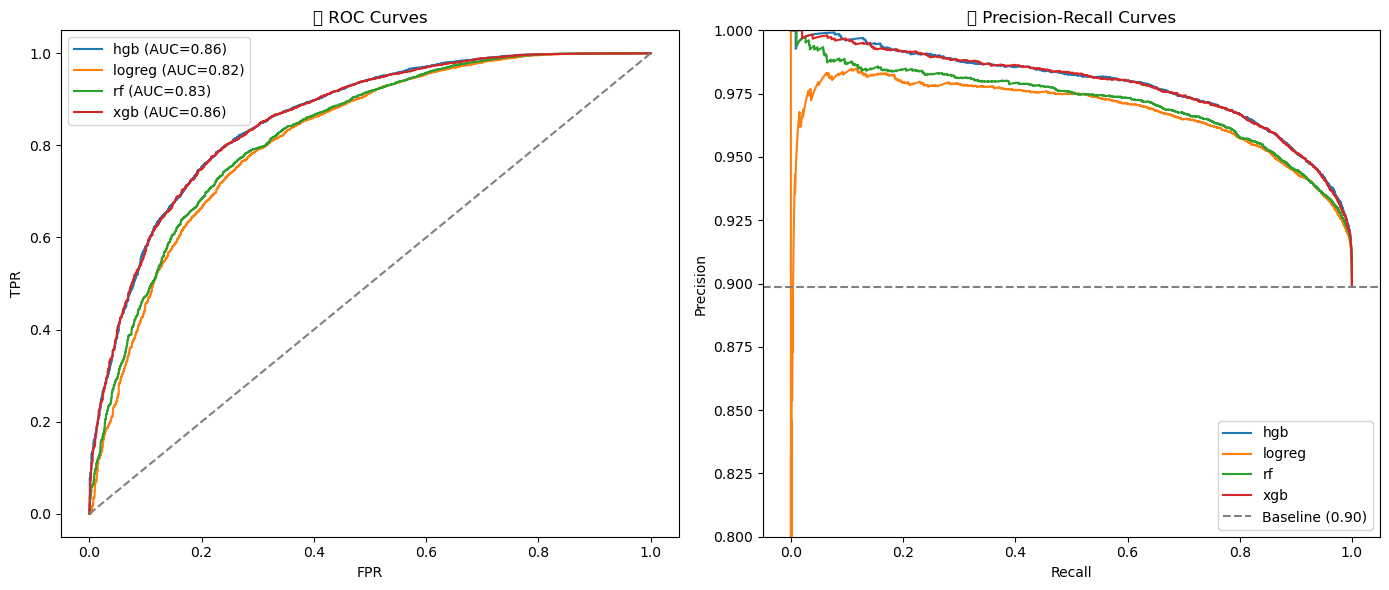

,Modelo,AUC,F1-score,Precision,Recall
0,hgb,0.857733,0.956761,0.923448,0.992566
3,xgb,0.857005,0.956428,0.922994,0.992374
2,rf,0.825177,0.955388,0.916524,0.997693
1,logreg,0.816869,0.955074,0.918665,0.994489


In [88]:
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, 
    confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import pandas as pd
import time

resultados_test = []

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title("🔵 ROC Curves")
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.subplot(1, 2, 2)
plt.title("🟠 Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")

for nombre, res in resultados.items():
    print(f"\n📊 Evaluando modelo: {nombre}")
    
    modelo = res["modelo"]
    
    start = time.time()
    y_proba = modelo.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)
    tiempo = time.time() - start

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    # Guardar en tabla
    resultados_test.append({
        "Modelo": nombre,
        "AUC": auc,
        "F1-score": f1,
        "Precision": prec,
        "Recall": rec
    })

    # Graficar ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.2f})")

    # Graficar Precision-Recall
    p, r, _ = precision_recall_curve(y_test, y_proba)
    plt.subplot(1, 2, 2)
    plt.plot(r, p, label=f"{nombre}")




# Mostrar curvas
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.legend()

plt.subplot(1, 2, 2)
plt.ylim(0.8, 1.0)  # 📉 Limita el eje Y
baseline = y_test['resultado_tratamiento_bin'].mean()
plt.axhline(y=baseline, color="gray", linestyle="--", label=f"Baseline ({baseline:.2f})")  # ➕ Línea baseline
plt.legend()
plt.tight_layout()

plt.savefig('Documentacion\\figures\\roc_pr_curves.png', dpi=300)  # Save the plot as PNG
plt.show()

# Mostrar tabla
df_resultados = pd.DataFrame(resultados_test).sort_values(by="AUC", ascending=False)
df_resultados


In [79]:
from collections import defaultdict
import pandas as pd

def get_grouped_importances(modelo, preprocessor, top_n=20):
    # 1. Extraer feature names transformados
    feature_names = preprocessor.get_feature_names_out()

    # 2. Extraer importancias crudas
    importances = pd.Series(
        modelo.named_steps["clf"].feature_importances_,
        index=feature_names
    )

    # 3. Agrupar por variable padre
    grouped = defaultdict(float)
    for full_feat, importance in importances.items():
        if full_feat.startswith("num__"):
            parent = full_feat.replace("num__", "")
        elif full_feat.startswith("cat__"):
            parent = full_feat.replace("cat__", "").rsplit("_", 1)[0]
        else:
            parent = full_feat
        grouped[parent] += importance

    # 4. Convertir a DataFrame ordenado
    df_grouped = (
        pd.DataFrame(grouped.items(), columns=["feature", "importance"])
        .sort_values(by="importance", ascending=False)
    )

    return df_grouped.head(top_n)
from collections import defaultdict
import pandas as pd

grouped_importance = defaultdict(float)


modelo_xgb = resultados["xgb"]["modelo"]  # Este es un Pipeline

# 1. Obtener nombres de features transformadas
feature_names = modelo_xgb.named_steps["preproc"].get_feature_names_out()

# 2. Obtener importancias del modelo
importances = pd.Series(
    modelo_xgb.named_steps["clf"].feature_importances_,
    index=feature_names
)


# asumimos que 'importances' es un Series con índice igual a feature_names
for full_feature, importance in importances.items():
    if full_feature.startswith("num__"):
        parent = full_feature.replace("num__", "")
    elif full_feature.startswith("cat__"):
        # cortar desde la derecha por si el nombre tiene "_"
        parent = full_feature.replace("cat__", "").rsplit("_", 1)[0]
    else:
        parent = full_feature  # fallback

    grouped_importance[parent] += importance

# Convertir a DataFrame
df_importancia_agrupada = (
    pd.DataFrame(grouped_importance.items(), columns=["feature", "importance"])
    .sort_values(by="importance", ascending=False)
)

print(df_importancia_agrupada.head(20))


                                              feature  importance
15                                      resultado_hiv    0.275710
0                                    dias_tratamiento    0.239159
1                                                edad    0.123784
16                                   tipo_resistencia    0.065328
17                                               sexo    0.047537
18                                              droga    0.036263
3                                            dep_mean    0.035337
4                                  poblacion_estimada    0.026606
5                                       index obesity    0.021829
7                                   densidad_estimada    0.017979
6                                               salud    0.014934
10               % de hogares en vivienda deficitaria    0.014334
8               % de hogares sin acceso a red cloacal    0.013186
12             Nivel de incidencia de pobreza crónica    0.012808
13        

In [83]:
# 1) Define your translation dictionary:
translation = {
    'resultado_hiv': 'HIV Status',
    'dias_tratamiento': 'Treatment Duration (days)',
    'edad': 'Age',
    'tipo_resistencia': 'Resistance Type',
    'sexo': 'Sex',
    'droga': 'Drug (test) Type',
    'dep_mean': 'Department‐level Mean Outcome',
    'poblacion_estimada': 'Estimated Population',
    'index obesity': 'Obesity Index',
    'densidad_estimada': 'Population Density',
    'salud': 'Health Coverage Score',
    '% de hogares en vivienda deficitaria': 'Pct. Households in Deficient Housing',
    '% de hogares sin acceso a red cloacal': 'Pct. Households without Sewage',
    'Nivel de incidencia de pobreza crónica': 'Chronic Poverty Incidence',
    'prov_mean': 'Province‐level Mean Outcome',
    '% de hogares con hacinamiento crítico': 'Pct. Households in Critical Overcrowding',
    '% de hogares con jefe/a con secundario incompleto o menos': 
        'Pct. Households, Head with Incomplete Secondary',
    '% de hogares con jefe/a con primario completo o menos': 
        'Pct. Households, Head with Primary or Less',
    'mes': 'Month'
}

# 2) Apply it to your DataFrame:
df_importancia_agrupada['feature_en'] = (
    df_importancia_agrupada['feature']
      .map(translation)
      .fillna(df_importancia_agrupada['feature'])  # fallback to original
)

# 3) If you want to plot with the English names:



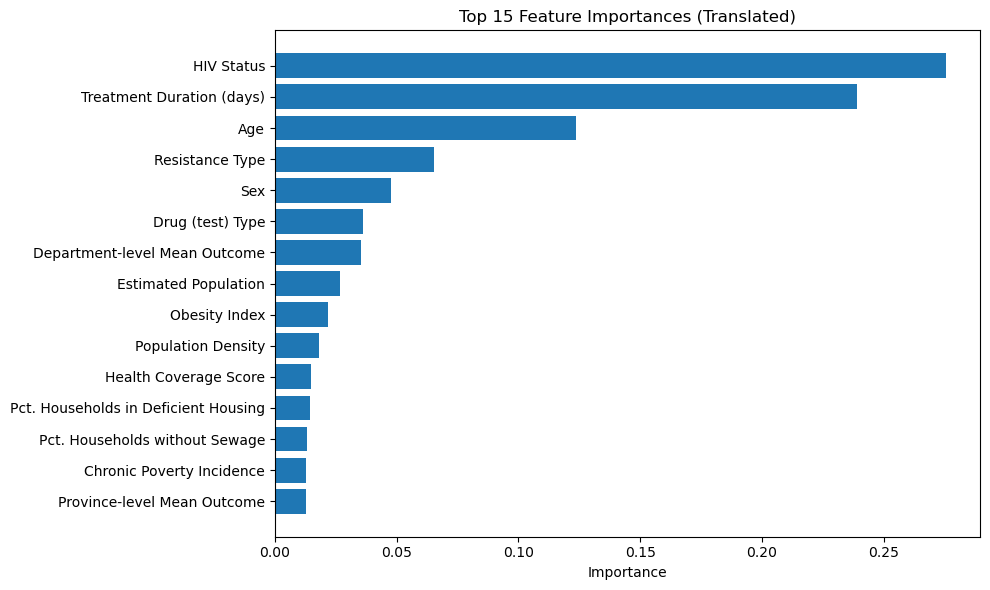

In [84]:
# Seleccionar top 15
top_n = 15
df_top = df_importancia_agrupada.head(top_n).copy()

# Traducir nombres
# df_top["feature_en"] = df_top["feature"].map(traduccion).fillna(df_top["feature"])

# Graficar
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(df_top["feature_en"][::-1], df_top["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances (Translated)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig('Documentacion\\figures\\xgb_importance.png', dpi=300)  # Save the plot as PNG

plt.show()


In [86]:
df_importancia_agrupada[["feature_en","importance"]]

,feature_en,importance
15,HIV Status,0.275710
0,Treatment Duration (days),0.239159
1,Age,0.123784
16,Resistance Type,0.065328
17,Sex,0.047537
18,Drug (test) Type,0.036263
3,Department‐level Mean Outcome,0.035337
4,Estimated Population,0.026606
5,Obesity Index,0.021829
7,Population Density,0.017979


In [81]:
df_importancia_agrupada

,feature,importance
15,resultado_hiv,0.275710
0,dias_tratamiento,0.239159
1,edad,0.123784
16,tipo_resistencia,0.065328
17,sexo,0.047537
18,droga,0.036263
3,dep_mean,0.035337
4,poblacion_estimada,0.026606
5,index obesity,0.021829
7,densidad_estimada,0.017979
